In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import ast
import json
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from ast import literal_eval
import math
import datetime
import warnings

from itertools import chain
import statistics
import os


warnings.filterwarnings('ignore')

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


# 0. conv 데이터 읽어오기 및 전처리


In [2]:
conv = pd.read_json('filtered_4weeks_at_home_final_with_categories_0530.json')
conv.drop(columns = ['Unnamed: 0', 'level_0'], inplace = True)
conv.head()

,index,log,uid,startTime,condition,answers,sceneStartTimes,sceneEndTimes,endTime,interactionMethods,main_category,sub_category,datetime
1,1,START,1,1668561601447,Maximum Time Interval,None,None,None,NaN,None,None,None,2022-11-16 01:20:01.447
2,2,START,1,1668566581682,Maximum Time Interval,None,None,None,NaN,None,None,None,2022-11-16 02:43:01.682
3,8,START,1,1668647968949,Maximum Time Interval,None,None,None,NaN,None,None,None,2022-11-17 01:19:28.949
4,25,START,1,1668820798068,Maximum Time Interval,None,None,None,NaN,None,None,None,2022-11-19 01:19:58.068
5,26,START,1,1668830759645,Maximum Time Interval,None,None,None,NaN,None,None,None,2022-11-19 04:05:59.645


### -  0.1 VUI/GUI column 전처리

In [3]:
def modality_fun(lst):
    lst = lst[1:-1]
    if "-1" in lst :
        return "LIKERT_ANSWER_NOT_COMPLETED"
    
    if 'voice' in lst and 'buttons' in lst : #둘다 사용한 경우 
        return "MIXED" #mixed 
    else:
        if 'buttons' in lst:
            return "GUI"
        else:
            return "VUI"

In [4]:
#interaction methods 열 전처리
conv['interactionMethods'] = conv['interactionMethods'].apply(lambda x : x[1:-1].split(', ') if not pd.isnull(x) else [x])
conv.reset_index(inplace = True)

In [5]:
#modality column 만들기
for i in range(0,len(conv)):
    #print(conv['interactionMethods'][i])
    if pd.isnull(conv['interactionMethods'][i]).all(): #nan 값 필터링
        #print("nan")
        continue
    
    for j in range(0,len(conv['interactionMethods'][i])):
        #print("for")
        if "'" in conv['interactionMethods'][i][j]:
            conv['interactionMethods'][i][j] = conv['interactionMethods'][i][j].replace("'","")

            conv['modality'] = conv['interactionMethods'].apply(modality_fun)

In [8]:
complete = conv[conv['log'] == "COMPLETE"]
#complete = complete[complete['condition'] != "Maximum Time Interval"]
vui = complete[complete['modality'] == "VUI"]
gui = complete[complete['modality'] == "GUI"]
mixed = complete[complete['modality'] == "MIXED"]

In [9]:
complete.head()

,level_0,index,log,uid,startTime,condition,answers,sceneStartTimes,sceneEndTimes,endTime,interactionMethods,main_category,sub_category,datetime,modality
1662,2336,4903,COMPLETE,1,1668571016343,Light,"['잤음', '1', '1', '1', '1', '4', '2', '공포 어지럽다']","[1668571035705, 1668571043685, 1668571051636, ...","[1668571043586, 1668571051542, 1668571056683, ...",1.668571e+12,"[voice, buttons, buttons, buttons, buttons, bu...",수면,수면,2022-11-16 03:56:56.343,GUI
1663,2340,4907,COMPLETE,1,1668600178044,Light,"['운동', '1', '1', '0', '0', '3', '3', '감시 당하고 있다']","[1668600194339, 1668600203922, 1668600212352, ...","[1668600203834, 1668600212262, 1668600217324, ...",1.668600e+12,"[voice, buttons, buttons, buttons, buttons, bu...",운동,운동,2022-11-16 12:02:58.044,GUI
1664,2342,4909,COMPLETE,1,1668602760657,CO2,"['유튜브', '0', '0', '0', '0', '2', '3', '키케 하다 +...","[1668602777269, 1668602785184, 1668602792594, ...","[1668602785083, 1668602792496, 1668602796409, ...",1.668603e+12,"[voice, buttons, buttons, buttons, buttons, bu...",미디어 사용,동영상 시청,2022-11-16 12:46:00.657,GUI
1665,2345,4912,COMPLETE,1,1668605405889,CO2,"['아이스크림 먹었음', '0', '0', '0', '0', '2', '4', '밟...","[1668605433777, 1668605442796, 1668605451948, ...","[1668605442683, 1668605451855, 1668605454738, ...",1.668605e+12,"[voice, buttons, buttons, buttons, buttons, bu...",음식,간식,2022-11-16 13:30:05.889,GUI
1666,2347,4914,COMPLETE,1,1668608128084,Human,"['유튜브 봤음', '0', '0', '0', '0', '2', '4', '높다']","[1668608154123, 1668608176020, 1668608180124, ...","[1668608175927, 1668608180017, 1668608182123, ...",1.668608e+12,"[voice, buttons, buttons, buttons, buttons, bu...",미디어 사용,동영상 시청,2022-11-16 14:15:28.084,GUI


# ===== 데이터 분석 코드 =====

## 관련 함수 정의 


In [10]:
def pie_chart_prev_action(df): #top_n : 상위 n개 카테고리만 선택
    
    result = df.groupby('main_category').count()
    
    common_cate = ['소셜인터랙션', '수면', '공부/업무', '음식', '휴식', '운동', '미디어 사용',
                   '개인위생','외출/귀가', '자기관리', '집안일', '기타']
    colors_cand = ['red','yellow','purple','goldenrod','lightcoral','aqua','pink','thistle','turquoise','deepskyblue', 'burlywood', 'gray']
    
    result = df.groupby('main_category').count()

    frequency = list(result['log'].values) #로그 개수 
    labels = list(result.index)
    print(frequency)
    print(labels)
    print("="*10)
    
    
    #비율 높은 순으로 정렬 
    sorted_labels = [label for _, label in sorted(zip(frequency, labels), reverse=True)]
    #colors = [color for _, color in sorted(zip(frequency, colors), reverse=True)]
    frequency.sort(reverse=True)
    
    # 기타 
    threshold = 3 #(threshold)퍼센트 미만은 기타 카테고리로 처리 
    etc_labels = []
    etc_frequency = 0
    
    to_remove_items = []
    for i in range(0,len(frequency)):
        if frequency[i]/len(df)*100 < threshold:
            etc_frequency += frequency[i]
            to_remove_items.append(sorted_labels[i])

    print(to_remove_items)
    for item in to_remove_items:
        idx = sorted_labels.index(item)
        sorted_labels.remove(item)
        del frequency[idx]

    sorted_labels.append("기타")
    frequency.append(etc_frequency)
    
    #컬러맵 만들어 주기 
    colors = []
    for label in sorted_labels:
        if label in common_cate:
            idx = common_cate.index(label)
            colors.append(colors_cand[idx])

    #그래프 그리기 
    plt.pie(frequency, labels=sorted_labels, autopct='%.1f%%', startangle=260, counterclock=True, colors = colors)
    #plt.title(title+"-"+str(len(df))+"개 응답 데이터")
    plt.title("직전 상황 카테고리 별 비율")
    plt.savefig('./직전상황카테고리별비율.svg')
    plt.show()


def visualize(df):
    max = len(df[df['condition'] == 'Maximum Time Interval'])
    co2 = len(df[df['condition'] == 'CO2'])
    noise = len(df[df['condition'] == 'Noise'])
    human = len(df[df['condition'] == 'Human'])
    light = len(df[df['condition'] == 'Light'])

    ratio = [max, co2, noise, human, light]
    labels = ['Time', 'CO2', 'Noise', 'Human', 'Light']

    colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0', '#adc178']
    wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

    plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors,
            wedgeprops=wedgeprops)
    plt.show()

    print("Trigger Distribution--------------------------")
    print("MAX: ", max)
    print("CO2: ", co2)
    print("Human: ", human)
    print("Light: ", light)
    print("Noise: ", noise)

    print("SUM: ", max + co2 + human + light + noise)


def visualize_subplot(df): # 트리거 distribution
    num_people = 20

    fig, axes = plt.subplots(4, 5)
    # 격자 크기 설정
    fig.set_size_inches((20, 15))

    # 격자 여백 설정
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    for i in range(1, num_people + 1):
        # UID별로 데이터 분리
        df_uid = df[df['uid'] == i].reset_index().sort_values('startTime', ignore_index=True)

        max = len(df_uid[df_uid['condition'] == 'Maximum Time Interval'])
        co2 = len(df_uid[df_uid['condition'] == 'CO2'])
        noise = len(df_uid[df_uid['condition'] == 'Noise'])
        human = len(df_uid[df_uid['condition'] == 'Human'])
        light = len(df_uid[df_uid['condition'] == 'Light'])
        # print(i, int(i/4), i%5, max)
        j = i - 1
        axes[j % 4, int(j / 4)].bar(['Time', 'CO2', 'Noise', 'Human', 'Light'], [max, co2, noise, human, light],
                                    color=['#ff9999', '#ffc000', '#8fd9b6', '#d395d0', '#adc178'], alpha=0.4)

        print("--------------------------")
        print("MAX: ", max)
        print("CO2: ", co2)
        print("Human: ", human)
        print("Light: ", light)
        print("Noise: ", noise)

        print("SUM: ", max + co2 + human + light + noise)

        # axes[int(j/4), j%4].bar(['CO2', 'Noise', 'Human', 'Light'], [co2, noise, human, light],
        #                         color = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0'], alpha = 0.4)
        axes[j % 4, int(j / 4)].set_title('uid = %i' % i, fontsize=12)
    plt.show()



def user_response_rate(df_start, df_complete, df_stop):
    n = 20
    df = pd.DataFrame()
    for uid in range(1, n + 1):
        df_start_user = df_start[df_start['uid'] == uid] # 유저별로 로그 데이터 분리
        df_start_user = df_start_user.copy()

        df_stop_user = df_stop[df_stop['uid'] == uid]  # 유저별로 로그 데이터 분리
        df_stop_user = df_stop_user.copy()

        df_complete_user = df_complete[df_complete['uid'] == uid]  # 유저별로 로그 데이터 분리
        df_complete_user = df_complete_user.copy()

        response_rate = (len(df_complete_user) + len(df_stop_user)) / (len(df_complete_user) + len(df_stop_user) + len(df_start_user))
        print("UID: ", uid, response_rate)
        df_temp = pd.DataFrame({'uid': [uid], 'response rate': [response_rate]})
        df = pd.concat([df, df_temp], ignore_index = True)
    return df

def trigger_response_distribution(df_start, df_complete):
    
    print("trigger_response_distribution")
    max_start = len(df_start[df_start['condition'] == 'Maximum Time Interval'])
    co2_start = len(df_start[df_start['condition'] == 'CO2'])
    noise_start = len(df_start[df_start['condition'] == 'Noise'])
    human_start = len(df_start[df_start['condition'] == 'Human'])
    light_start = len(df_start[df_start['condition'] == 'Light'])

    max_complete = len(df_complete[df_complete['condition'] == 'Maximum Time Interval'])
    co2_complete = len(df_complete[df_complete['condition'] == 'CO2'])
    noise_complete = len(df_complete[df_complete['condition'] == 'Noise'])
    human_complete = len(df_complete[df_complete['condition'] == 'Human'])
    light_complete = len(df_complete[df_complete['condition'] == 'Light'])

    max_ = round(max_complete / max_start, 2)
    co2 = round(co2_complete / co2_start, 2)
    human = round(human_complete / human_start, 2)
    light = round(light_complete / light_start, 2)
    noise = round(noise_complete / noise_start, 2)
    
    print("="*10)
    print("각 트리거 타입 별 응답 완료, 트리거 횟수")
    print("time trigger", max_complete, max_start )
    print("co2 trigger", co2_complete, co2_start )
    print("human ", human_complete, human_start)
    print("light ", light_complete, light_start)
    print("noise ", noise_complete, noise_start)
    

    ratio = [max_, co2, noise, human, light]
    labels = ['Time', 'CO2', 'Noise', 'Human', 'Light']
    
    print("="*10)
    print("각 트리거 타입 별 응답률")
    print(labels)
    print(ratio)

    colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0', '#adc178']
    wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

    plt.bar(labels, ratio, color=colors)
    plt.show()

    #print("--------------------------")
    #print("Time: ", max)
    #print("CO2: ", co2)
    #print("Human: ", human)
    #print("Light: ", light)
    #print("Noise: ", noise)

    print("SUM: ", round((max_complete + co2_complete + human_complete + light_complete + noise_complete) / (
                max_start + co2_start + human_start + light_start + noise_start), 2))



def pre_context_extraction(df):
    # 트리거 타입 별로 데이터 분리
    df_context = df['answers']
    pre_context = []
    for i in range(0, len(df_context)):
        # print(df_context[i])
        if df_context[i] is None:
            pre_context.append(None)
            continue
        if df_context[i][0] == -100:
            pre_context.append(None)
        else:
            pre_context.append(df_context[i][0])

    # print(len(pre_context), len(df))
    # 컬럼 추가
    df.insert(4, 'context', pre_context)

    # print(df.info())

    return df

def trigger_type_context(df):
    trigger_type = ['Maximum Time Interval', 'CO2', 'Noise', 'Human', 'Light']

    uid = []
    log = []
    context = []
    condition = []
    timestamp = []
    for trigger_condition in trigger_type:
        # 트리거 타입 별로 데이터 분리
        df_trigger = df[df['condition'] == trigger_condition].reset_index()

        for j in range(0, len(df_trigger['context'])):
            if df_trigger['context'][j] is None:
                continue
            uid.append(df_trigger['uid'][j])
            log.append(df_trigger['log'][j])
            context.append(df_trigger['context'][j])
            condition.append(df_trigger['condition'][j])
            timestamp.append(df_trigger['startTime'][j])
            # print("log Type: ", df_trigger['log'][j], "\t Trigger Type: ", df_trigger['condition'][j], "\t 직전 상황: ", df_trigger['context'][j])

    df_trigger_context = pd.DataFrame({'log': log, 'uid': uid, 'condition': condition, 'context': context, 'timestamp': timestamp})
    df_trigger_context.to_csv('./trigger_context.csv')
    
    

def sensor_pie_chart(sensor_label, df): #top_n : 상위 n개 카테고리만 선택
    df_sensor = df[df['condition'] == sensor_label]
    df = df_sensor
    print("len df_sensor")
    print(len(df_sensor))
    result = df_sensor.groupby('main_category').count()
    
    common_cate = ['소셜인터랙션', '수면', '공부/업무', '음식', '휴식', '운동', '미디어 사용',
                   '개인위생','외출/귀가', '자기관리', '집안일', '기타']
    colors_cand = ['red','yellow','purple','goldenrod','lightcoral','aqua','pink','thistle','turquoise','deepskyblue', 'burlywood', 'gray']
    
    result = df.groupby('main_category').count()

    frequency = list(result['log'].values) #로그 개수 
    labels = list(result.index)
    print(frequency)
    print(labels)
    print("="*10)
    
    
    #비율 높은 순으로 정렬 
    sorted_labels = [label for _, label in sorted(zip(frequency, labels), reverse=True)]
    #colors = [color for _, color in sorted(zip(frequency, colors), reverse=True)]
    frequency.sort(reverse=True)
    
    # 기타 
    threshold = 3 #(threshold)퍼센트 미만은 기타 카테고리로 처리 
    etc_labels = []
    etc_frequency = 0
    
    to_remove_items = []
    for i in range(0,len(frequency)):
        if frequency[i]/len(df)*100 < threshold:
            etc_frequency += frequency[i]
            to_remove_items.append(sorted_labels[i])

    print(to_remove_items)
    for item in to_remove_items:
        idx = sorted_labels.index(item)
        sorted_labels.remove(item)
        del frequency[idx]

    sorted_labels.append("기타")
    frequency.append(etc_frequency)
    
    #컬러맵 만들어 주기 
    colors = []
    for label in sorted_labels:
        if label in common_cate:
            idx = common_cate.index(label)
            colors.append(colors_cand[idx])

    #그래프 그리기 
    plt.pie(frequency, labels=sorted_labels, autopct='%.1f%%', startangle=260, counterclock=True, colors = colors)
    #plt.title(title+"-"+str(len(df))+"개 응답 데이터")
    plt.title(sensor_label+"-직전 상황-"+str(len(df_sensor))+"개")
    plt.savefig(sensor_label+'.svg')
    plt.show()
    
def func1(df): #사용자별 응답 요청 횟수 및 응답 횟수를 df로 만들어주는 함수
    num_trigger_lst = []
    num_response_lst = []
    uid_lst = []
    
    for uid in range(1,21):
        
        df_user = df[df["uid"] == uid]
        num_trigger = len(df_user) #사용자 별 응답 요청된 횟수
        
        df_complete = df_user[df_user["log"] == "COMPLETE"]
        num_response = len(df_complete) #사용자 별로 응답 완료한 횟수
        
        num_trigger_lst.append(num_trigger)
        num_response_lst.append(num_response)
        uid_lst.append(uid)
        
    result = pd.DataFrame(columns = ['사용자 아이디', '요청 횟수(회)', '응답 횟수(회)'])
    result['사용자 아이디'] = uid_lst
    result['요청 횟수(회)'] = num_trigger_lst
    result['응답 횟수(회)'] = num_response_lst
    result['미응답 횟수(회)'] = result['요청 횟수(회)']-result['응답 횟수(회)']
    
    
    return result

def response_time(df): #df: complete이 들어 올 것임 
    
    result = []
    #1. 각 사용자 별로 응답 소요 시간 포함한 df_user 만들기(열 : startTime, EndTime, 소요시간(초))
    for uid in range(1,21):
        startTimes = []
        endTimes = []
        
        df_ = df[df['uid'] == uid]
        #print("len(df)",len(df_))
        startTimes = list(df_['sceneStartTimes'].apply(lambda x:literal_eval(x)[0])) #start 버튼 누른 시각
        endTimes = list(df_['endTime'])
        
        df_user = pd.DataFrame(columns = ["응답시작 시각", "응답완료 시각", "소요시간(초)"])
        df_user["응답시작 시각"] = startTimes
        df_user["응답완료 시각"] = endTimes
        df_user["소요시간(초)"] = round(((-1)*df_user["응답시작 시각"] + df_user["응답완료 시각"])/1000.0, 1)
        
        result.append(list(df_user["소요시간(초)"]))
    
    #평균 응답 시간 계산
    total = 0
    count = 0
    for i in range(len(result)):
        for j in range(len(result[i])):
            if result[i][j] <= 100000:
                total += result[i][j]
                count +=1

    avg = total/count
    print('평균 설문 응답 시간 :' , str(avg)+"초")
    
    
    #표준편차 계산
    flatten_list = list(chain.from_iterable(result))
    new_lst = []
    for i in range(len(flatten_list)):
        if flatten_list[i] <= 100000:
            new_lst.append(flatten_list[i])

    print('설문 응답 시간 표준편차:' , str(statistics.stdev(new_lst))+"초")
    
    

    return result #2차원 배열, 각 element에는 사용자별 설문 응답 시간 list가 존재


def pie_chart(df, modality): # modality: 응답 방식(vui, gui or mixed)
    plt.rc('font', size=10) 
    
    common_cate = ['소셜인터랙션', '수면', '공부/업무', '음식', '휴식', '운동', '미디어 사용',
                   '개인위생','외출/귀가', '자기관리', '집안일', '기타']
    colors_cand = ['red','yellow','purple','goldenrod','lightcoral','aqua','pink','thistle','turquoise','deepskyblue', 'burlywood', 'gray']
    
    result = df.groupby('main_category').count()

    frequency = list(result['log'].values) #로그 개수 
    labels = list(result.index)
    
    #비율 높은 순으로 정렬 
    sorted_labels = [label for _, label in sorted(zip(frequency, labels), reverse=True)]
    #colors = [color for _, color in sorted(zip(frequency, colors), reverse=True)]
    frequency.sort(reverse=True)
    
    # 기타 
    threshold = 3 #(threshold)퍼센트 미만은 기타 카테고리로 처리 
    etc_labels = []
    etc_frequency = 0
    
    to_remove_items = []
    for i in range(0,len(frequency)):
        if frequency[i]/len(df)*100 < threshold:
            etc_frequency += frequency[i]
            to_remove_items.append(sorted_labels[i])

    for item in to_remove_items:
        idx = sorted_labels.index(item)
        sorted_labels.remove(item)
        del frequency[idx]

    sorted_labels.append("기타")
    frequency.append(etc_frequency)
    
    #컬러맵 만들어 주기 
    colors = []
    for label in sorted_labels:
        if label in common_cate:
            idx = common_cate.index(label)
            colors.append(colors_cand[idx])

    #그래프 그리기 
    plt.pie(frequency, labels=sorted_labels, autopct='%.1f%%', startangle=260, counterclock=True, colors = colors)
    plt.title(modality+"-"+str(len(df))+"개 응답 데이터")
    plt.savefig(modality+'.svg') #.svg 형식으로 저장함. 이미지 형식 바꿔
    plt.show()
    
def whichPeriods(datetime,period_range_lst):
    for i in range(len(period_range_lst)):
        start_dt, end_dt = period_range_lst[i][0], period_range_lst[i][1]
        if start_dt <=datetime<= end_dt: 
            result = i+1 #몇 번째 주차인가? 
            return result
            

def periods_count_per_users(uid, df, start_day, end_day, period):
    ##input : uid, startday
    #start_day = '2022-12-02'
    start_datetime = datetime.datetime.strptime(start_day, '%Y-%m-%d').date()

    #end_day = '2022-12-31'
    end_datetime = datetime.datetime.strptime(end_day, '%Y-%m-%d').date()

    ##유저별 df sorting 
    user = df[df['uid'] == uid]
    user.sort_values(by = 'startTime', inplace =True)

    user['date'] = pd.to_datetime(user['startTime'], unit='ms').dt.date


    ##주차별 각 모달리티 빈도수 카운트
    #사용자별 주 시작 날짜와 끝 날짜 구하기
    week_starts = []
    week_ends = []

    temp = start_day
    while True:
        start = temp
        week_range = pd.date_range(start, periods=period).date
        #if week_range[-1] > end_datetime: 
        if week_range[0] > end_datetime: 
            break

        week_starts.append(week_range[0])
        week_ends.append(week_range[-1])
        temp = week_range[-1] + datetime.timedelta(days=1)
        
        
    #print("week_starts", week_starts)
    #print("week_ends", week_ends)
    

    week_range_lst = [[start, end] for start, end in zip(week_starts, week_ends)]

    #기간별 column 만들기
    user['periods'] = user['date'].apply(lambda x: whichPeriods(x,week_range_lst))
    user = pd.get_dummies(user, columns = ['modality'])

    #날짜 별로 각 모달리티 사용 빈도수 카운트
    result = user.groupby('periods').sum()

    """freq_GUI = list(result['modality_GUI'])
    freq_MIXED = list(result['modality_MIXED'])
    freq_VUI = list(result['modality_VUI'])"""

    cols = ['modality_GUI','modality_MIXED', 'modality_VUI']

    d = {'modality_GUI': max_week_count*[0], 'modality_MIXED':max_week_count*[0], 'modality_VUI':max_week_count*[0]}


    for col_name in cols :
        if col_name in result.columns:
            #print("col_name", col_name)
            freq = list(result[col_name])
            len_week = len(freq)
            e = max_week_count-len_week
            freq.extend([0]*e)
            d[col_name] = freq
            #print('freq_lst', freq)
            #print('d[col_name]', d[col_name])
    #print("UID",uid )      
    #print(d)
    
    #print("UID", uid, sum(d['modality_GUI'])+sum(d['modality_MIXED'])+sum(d['modality_VUI']))
    #print("="*10)
    
    #전체 합산
    for i in range(len(result_lst)):
        if i == 0 : #GUI
            result_lst[i]= [sum(elem) for elem in zip(result_lst[i], d['modality_GUI'])]
        elif i == 1: #MIXED
            result_lst[i]= [sum(elem) for elem in zip(result_lst[i], d['modality_MIXED'])]
        elif i == 2: #VUI
            result_lst[i]= [sum(elem) for elem in zip(result_lst[i], d['modality_VUI'])]
            
    
    return user

def draw_graph_individual(uid, df):
    user = df[df['uid'] == uid]
    user.sort_values(by = 'startTime', inplace =True)

    user['date'] = pd.to_datetime(user['startTime'], unit='ms')
    #dates = user['date'].dt.strftime("%Y-%m-%d").values

    user['date'] = pd.to_datetime(user['startTime'], unit='ms').dt.date
    #dates = user['date'].dt.strftime("%Y-%m-%d").values

    user = pd.get_dummies(user, columns = ['modality'])

    #날짜 별로 각 모달리티 사용 빈도 세기
    result = user.groupby('date').sum()

    cols = ['modality_GUI','modality_MIXED', 'modality_VUI']

    d = {'modality_GUI':[0]*len(result), 'modality_MIXED':[0]*len(result), 'modality_VUI':[0]*len(result)}

    for col_name in cols :
        if col_name in result.columns:
            d[col_name] = list(result[col_name])

    gui_freq = d['modality_GUI']
    mixed_freq = d['modality_MIXED']
    vui_freq = d['modality_VUI']
    
    print("gui_freq", sum(gui_freq))
    print("mixed_freq", sum(mixed_freq))
    print("vui_freq", sum(vui_freq))
    

    dates = result.index

    #그래프 그리기 
    ind = np.arange(len(dates))    
    width = 0.35 
    
    print("UID", uid, sum(gui_freq)+sum(mixed_freq)+sum(vui_freq))

    p1 = plt.bar(ind, gui_freq, width, color='#d62728')
    p2 = plt.bar(ind, mixed_freq, width,  bottom=gui_freq)
    #p3 = plt.bar(ind, vui_freq, width,  bottom=gui_freq+mixed_freq)
    tupSum=tuple(sum(elem) for elem in zip(mixed_freq, vui_freq))
    p3 = plt.bar(ind, vui_freq, width,  bottom=tupSum)

    plt.ylabel('빈도수(회)')
    plt.title('날짜별 모달리티 사용 빈도 (uid:'+str(uid)+')')
    plt.xticks(ind, dates)
    plt.yticks(np.arange(0, 30, 10))
    plt.legend((p1[0], p2[0], p3[0]), ('GUI', 'MIXED', "VUI"))

    plt.show()
    #return result 


# 6.2.2. 직전 상황 카테고리 비율 

[75, 369, 19, 748, 90, 184, 94, 12, 211, 49, 114, 236]
['개인위생', '공부/업무', '기타', '미디어 사용', '소셜인터랙션', '수면', '외출/귀가', '운동', '음식', '자기관리', '집안일', '휴식']
['자기관리', '기타', '운동']


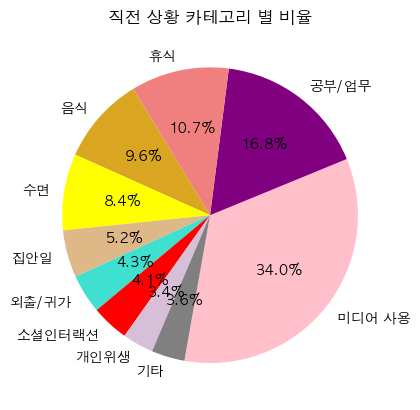

In [11]:
complete = conv[conv['log'] == "COMPLETE"]
pie_chart_prev_action(complete)

# 7.1 분석 

## 그림 7.1 설문 트리거 타입 별 설문 응답률 & 표 7.1 설문 트리거 타입 별 설문 응답 횟수, 요청횟수, 응답률


In [12]:
df_final = pd.read_json('./filtered_4weeks_at_home_final_with_categories_0530.json')  ## pd.read_json 이용
df_final.drop(['level_0', 'Unnamed: 0'], axis = 1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3863 entries, 1 to 4946
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               3863 non-null   int64         
 1   log                 3863 non-null   object        
 2   uid                 3863 non-null   int64         
 3   startTime           3863 non-null   int64         
 4   condition           3863 non-null   object        
 5   answers             2275 non-null   object        
 6   sceneStartTimes     2275 non-null   object        
 7   sceneEndTimes       2275 non-null   object        
 8   endTime             2275 non-null   float64       
 9   interactionMethods  2275 non-null   object        
 10  main_category       2273 non-null   object        
 11  sub_category        2273 non-null   object        
 12  datetime            3863 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), obje

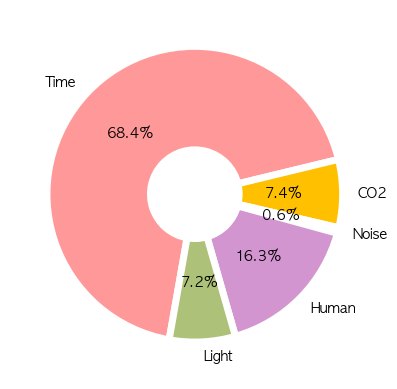

Trigger Distribution--------------------------
MAX:  1557
CO2:  169
Human:  371
Light:  164
Noise:  14
SUM:  2275


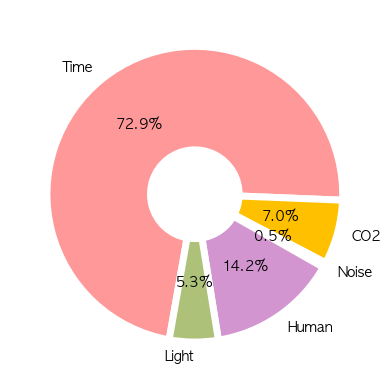

Trigger Distribution--------------------------
MAX:  2815
CO2:  272
Human:  549
Light:  206
Noise:  21
SUM:  3863
trigger_response_distribution
각 트리거 타입 별 응답 완료, 트리거 횟수
time trigger 1502 2815
co2 trigger 164 272
human  364 549
light  157 206
noise  14 21
각 트리거 타입 별 응답률
['Time', 'CO2', 'Noise', 'Human', 'Light']
[0.53, 0.6, 0.67, 0.66, 0.76]


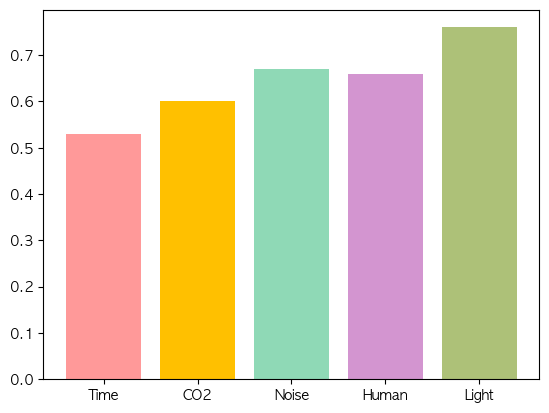

SUM:  0.57
index                    0
log                      0
uid                      0
startTime                0
condition                0
answers               1588
sceneStartTimes       1588
sceneEndTimes         1588
endTime               1588
interactionMethods    1588
main_category         1588
sub_category          1588
datetime                 0
dtype: int64
index                 0
log                   0
uid                   0
startTime             0
condition             0
answers               0
sceneStartTimes       0
sceneEndTimes         0
endTime               0
interactionMethods    0
main_category         0
sub_category          0
datetime              0
dtype: int64
index                 0
log                   0
uid                   0
startTime             0
condition             0
answers               0
sceneStartTimes       0
sceneEndTimes         0
endTime               0
interactionMethods    0
main_category         2
sub_category          2
datetime    

In [13]:

print(df_final.info())

#df_final = pre_context_extraction(df_final)
#trigger_type_context(df_final)


df_start = df_final[df_final['log'] == 'START']
df_stop = df_final[df_final['log'] == 'STOP']
df_complete = df_final[df_final['log'] == 'COMPLETE']


#
#
# # visualize(df_start)
# 트리거 된 경우
df_trigger = df_final.copy()

# 응답을 한 경우
df_response = pd.concat([df_stop, df_complete], ignore_index=True, join='inner')
df_tried = df_response.drop_duplicates(['startTime'], keep='last')

# visualize_subplot(df_start)
visualize(df_tried)
#
# # 응답을 끝까지 한 경우
visualize(df_trigger)
# trigger_response_distribution(df_start, df_tried)
trigger_response_distribution(df_trigger, df_complete)
print(df_start.isnull().sum())
print(df_complete.isnull().sum())
print(df_stop.isnull().sum())

## 표 7.2 다층 로지스틱 회귀 분석 결과

- R markdown 파일 참고

## 그림 7.2 트리거 타입 별 직전 상황 

len df_sensor
157
[16, 16, 34, 3, 15, 11, 1, 18, 12, 20, 11]
['개인위생', '공부/업무', '미디어 사용', '소셜인터랙션', '수면', '외출/귀가', '운동', '음식', '자기관리', '집안일', '휴식']
['소셜인터랙션', '운동']


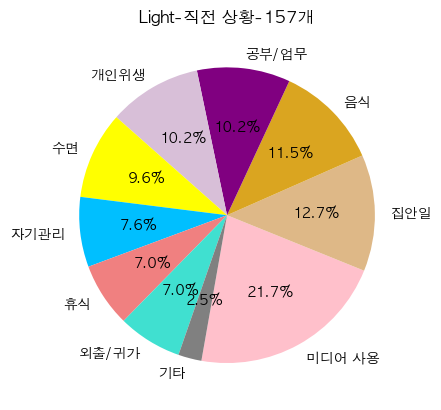

In [14]:
sensor_pie_chart("Light", complete)

len df_sensor
164
[3, 41, 1, 60, 1, 9, 6, 19, 3, 7, 14]
['개인위생', '공부/업무', '기타', '미디어 사용', '소셜인터랙션', '수면', '외출/귀가', '음식', '자기관리', '집안일', '휴식']
['자기관리', '개인위생', '소셜인터랙션', '기타']


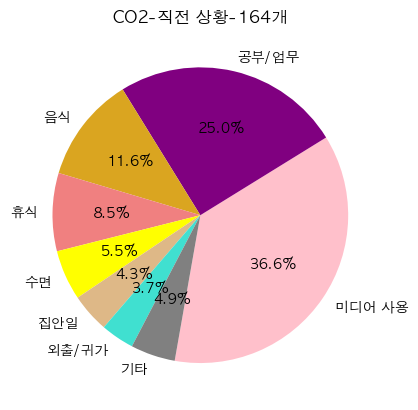

In [15]:
sensor_pie_chart("CO2", complete)

len df_sensor
14
[1, 8, 1, 1, 3]
['공부/업무', '미디어 사용', '소셜인터랙션', '외출/귀가', '휴식']
[]


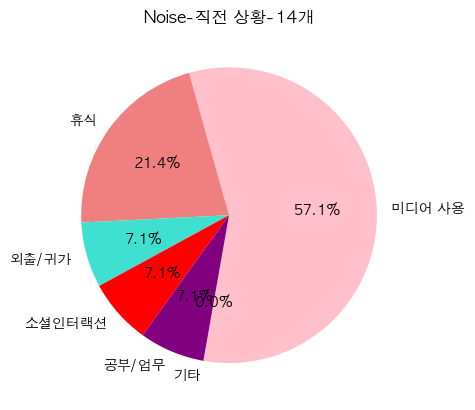

In [17]:
sensor_pie_chart("Noise", complete)

len df_sensor
364
[26, 51, 4, 138, 7, 10, 29, 1, 30, 17, 34, 17]
['개인위생', '공부/업무', '기타', '미디어 사용', '소셜인터랙션', '수면', '외출/귀가', '운동', '음식', '자기관리', '집안일', '휴식']
['수면', '소셜인터랙션', '기타', '운동']


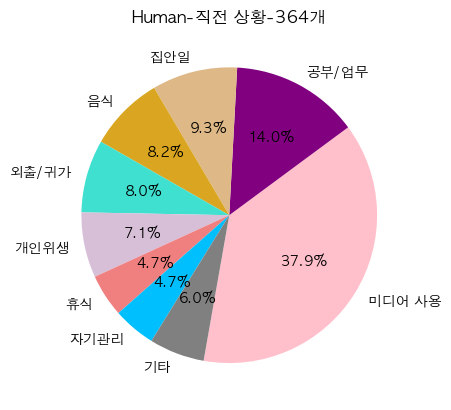

In [18]:
sensor_pie_chart("Human", complete)

# 7.2 분석 

## 그림 7.3 사용자 별 ESM 설문 응답 및 미응답 횟수

In [19]:
result = func1(conv)
result

x = list(result['사용자 아이디'])
no_response = list(result['미응답 횟수(회)'])
response = list(result['응답 횟수(회)'])

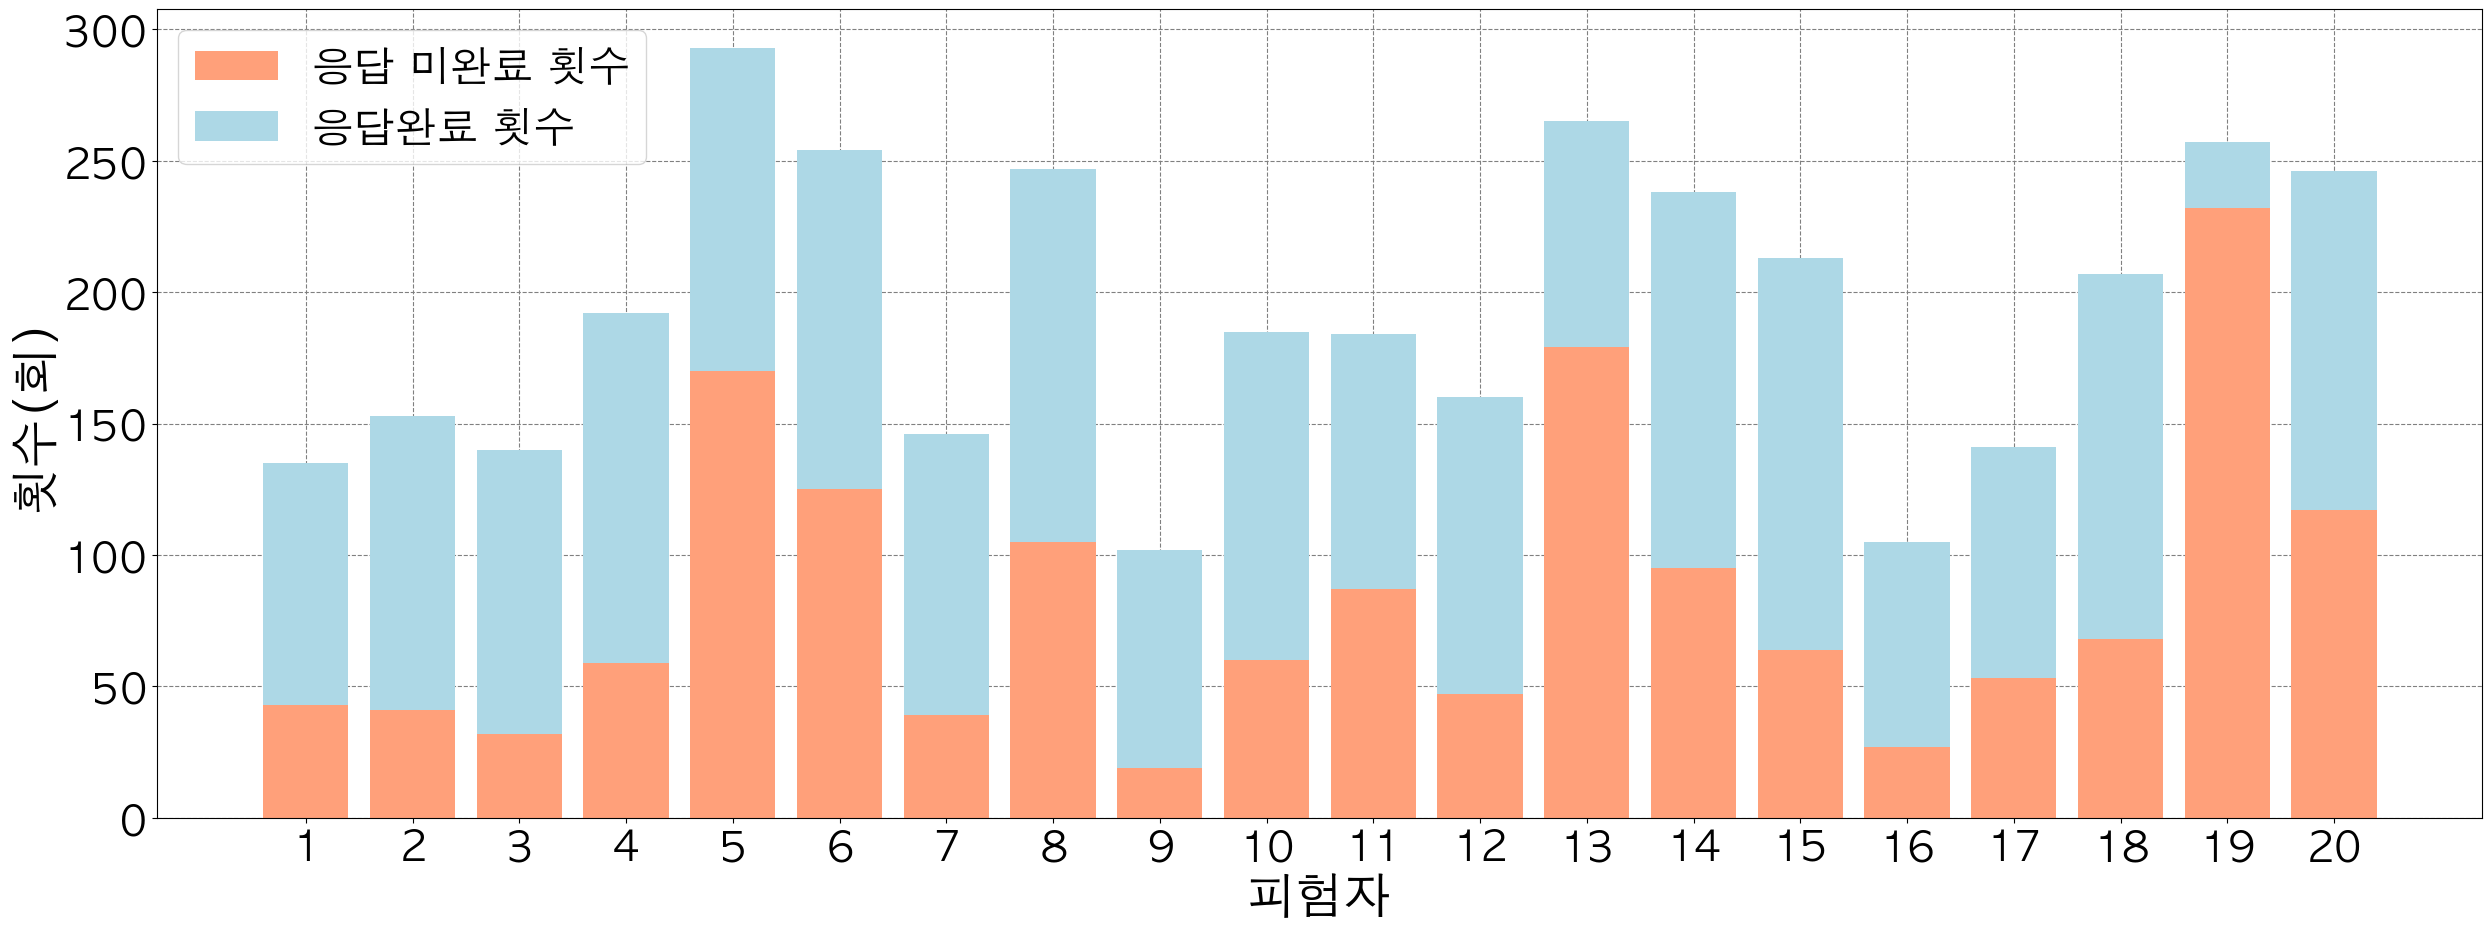

In [20]:
#그래프 그리기
plt.rc('font', size=30) 
fig, ax = plt.subplots()
fig.set_size_inches(30, 10.5, forward=True) #plot 사이즈 조절 
fig.set_dpi(100) #화질 설정


plt.bar(x, no_response, color='lightsalmon')
plt.bar(x, response, bottom=no_response, color='lightblue') #'lightblue'
labels_legend = ['응답 미완료 횟수', '응답완료 횟수']
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')


ax.legend(labels=labels_legend)

plt.xticks(x)
plt.xlabel("피험자", fontsize=35)
plt.ylabel("횟수(회)", fontsize=35)
plt.savefig("num_of_response.svg") #.svg 형식으로 저장하기

## 2) 사용자 별 응답 시간

### : #scenestartTime[0] : 시작 버튼 누른 시점 ~ endTime: 응답 완료한 시점

In [21]:
result2 = response_time(complete)

평균 설문 응답 시간 : 59.5025489303595초
설문 응답 시간 표준편차: 21.267620421231857초


In [22]:
len(result2)

20

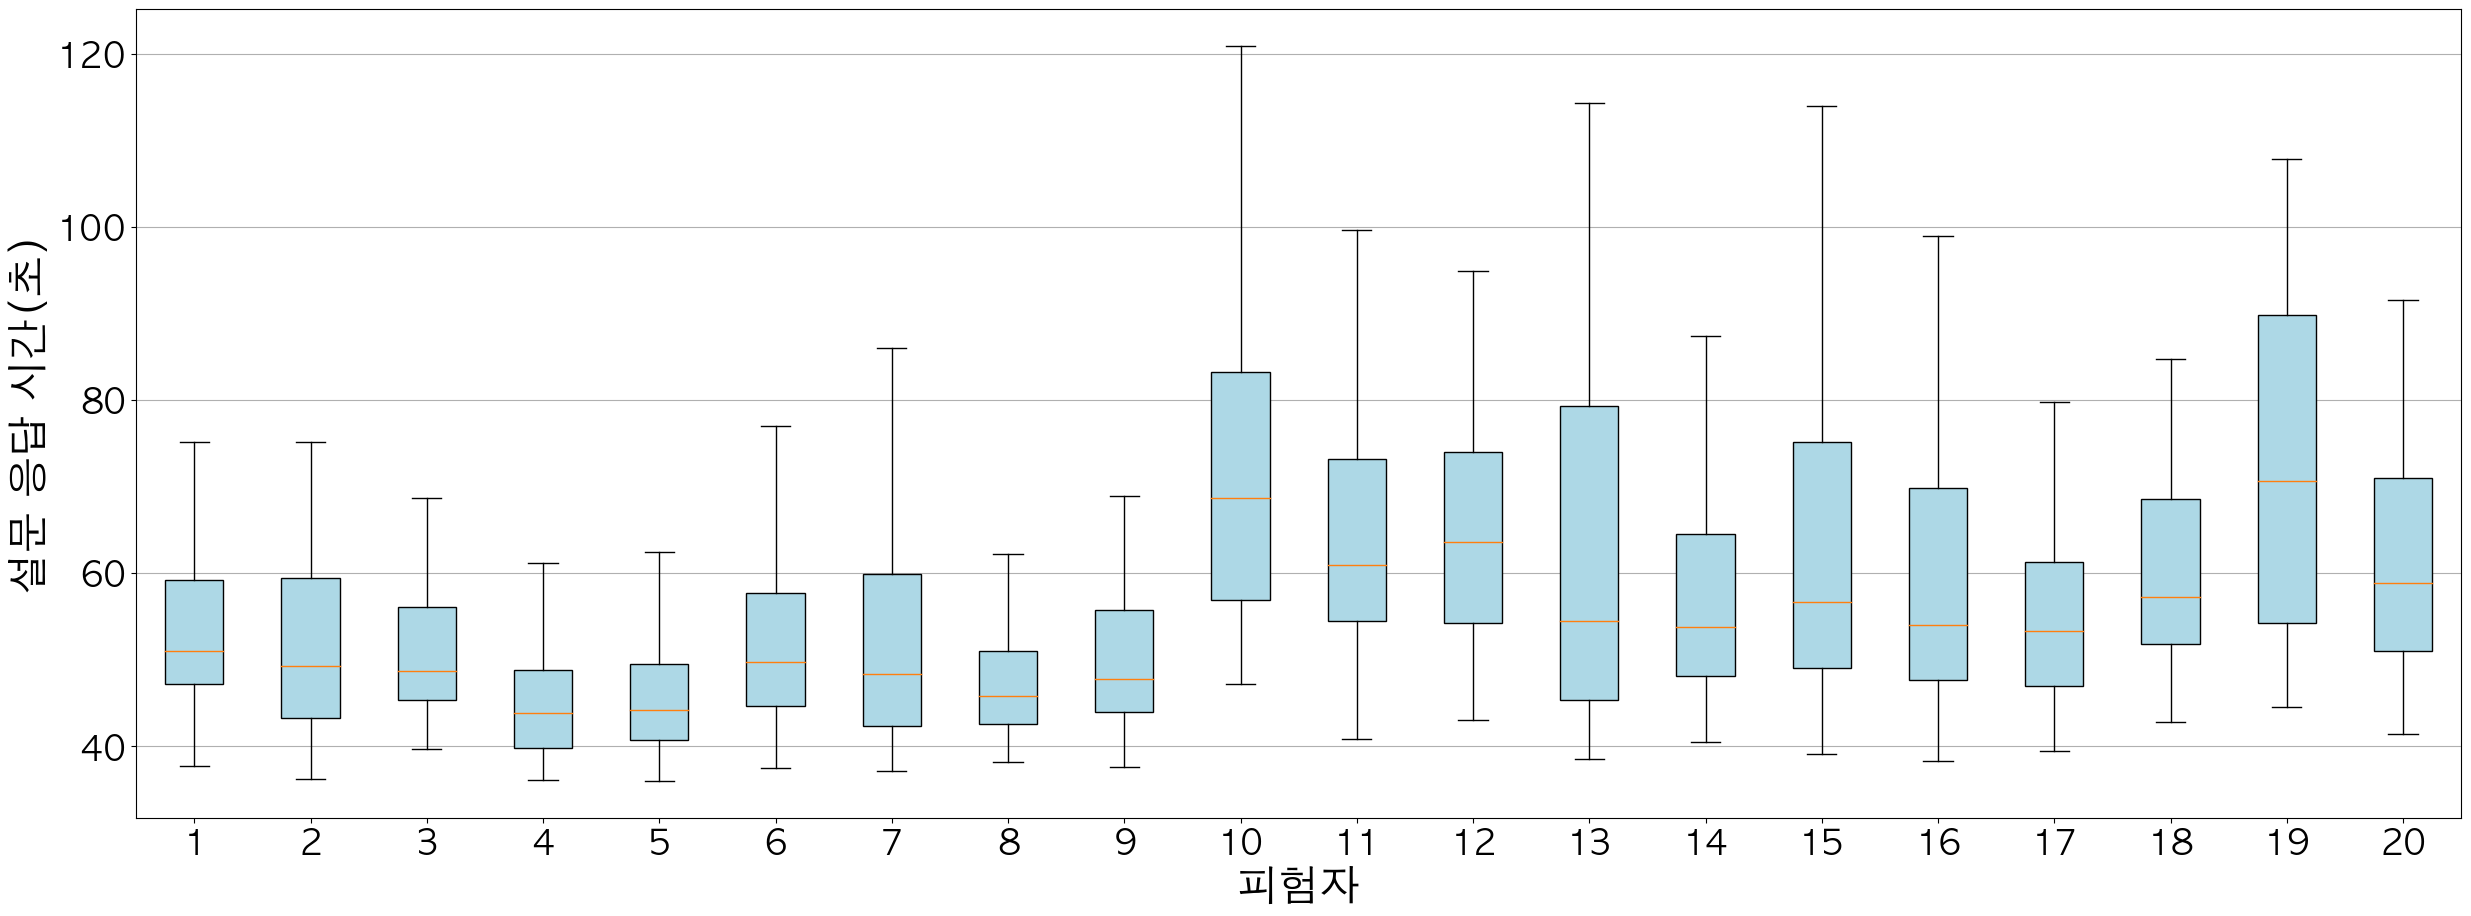

In [23]:
#그래프 그리기
plt.rc('font', size=25) 
fig, ax = plt.subplots()

bplot = ax.boxplot(result2, sym='r+', vert=1,patch_artist=True, showfliers=False)

fig.set_size_inches(30, 10.5, forward=True) #plot 사이즈 조절 
fig.set_dpi(100) #화질 설정

#legend 설정
ax.set_xlabel('피험자', fontsize = 30)
ax.set_ylabel('설문 응답 시간(초)', fontsize = 30)

#색상 설정 
for patch in bplot['boxes']:
    #patch.set_facecolor((161,218,232))
    patch.set_facecolor('lightblue') #colors = ['pink', 'lightblue', 'lightgreen']

    
ax.yaxis.grid(True)

plt.savefig("response_times.svg")


## 표 7.3 응답 방식 별 사용 비율 및 횟수

In [24]:
gui_cnt= len(complete[complete['modality'] == "GUI"])
vui_cnt = len(complete[complete['modality'] == "VUI"])
mixed_cnt = len(complete[complete['modality'] == "MIXED"])

print("GUI 횟수-",gui_cnt, "GUI 비율-",gui_cnt/len(complete))
print("VUI 횟수-",vui_cnt, "VUI 비율-",vui_cnt/len(complete))
print("MIXED 횟수-",mixed_cnt, "MIXED 비율-",mixed_cnt/len(complete))

GUI 횟수- 2065 GUI 비율- 0.9382099045888233
VUI 횟수- 60 VUI 비율- 0.027260336210813266
MIXED 횟수- 76 MIXED 비율- 0.03452975920036347


## 그림 7.5 : 각 모달리티 별 응답 직전 상황 분석 결과 
: 각 모달리티 별로 응답 직전 상황 파이차트 그려줌 & 마지막에 이미지 저장

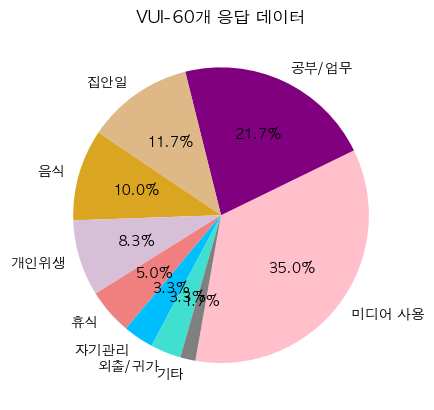

In [25]:
pie_chart(vui, "VUI")

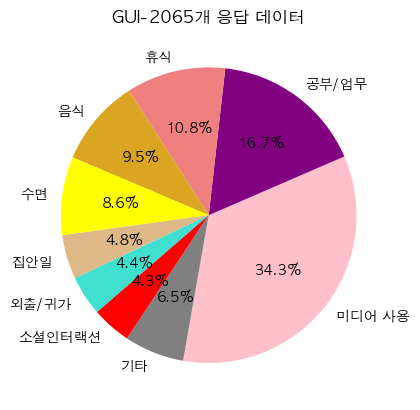

In [26]:
pie_chart(gui, "GUI")

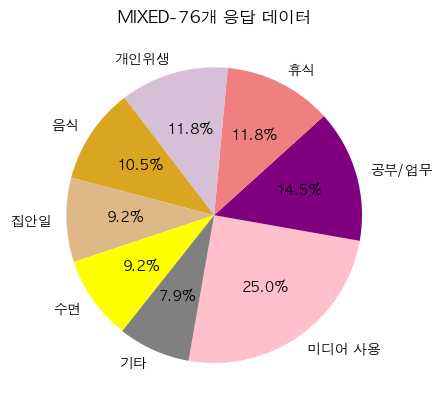

In [27]:
pie_chart(mixed, "MIXED")

## 표 7.4 실험 주차 별 응답 방식 사용 비율 

In [28]:
max_week_count = 8
result_lst = [[0]*max_week_count for _ in range(3)] #이중 배열 


#To-Do : 4주간 실험자 별로 시작 일자와 종료 일자 지정
start_days = ['2022-11-16','2022-11-16', '2022-11-17',  '2022-11-17',  '2022-11-17', 
              '2022-11-17',  '2022-11-23',  '2022-11-24',  '2022-11-22',  '2022-11-22', 
              '2022-11-22', '2022-11-23', '2022-11-22', '2022-11-23', '2022-11-23', 
             '2022-12-01','2022-12-01', '2022-12-03', '2022-12-02', '2022-12-02' ]

end_days = ['2022-12-13','2022-12-13', '2022-12-14',  '2022-12-14',  '2022-12-16',
           '2022-12-14', '2022-12-20', '2022-12-20', '2022-12-19', '2022-12-19', 
           '2022-12-19', '2022-12-20', '2022-12-19', '2022-12-20', '2022-12-20', 
           '2022-12-18', '2022-12-18', '2023-12-30', '2022-12-29', '2022-12-29']

In [29]:
#실행
for i in range(20):
    uid = i+1
    periods_count_per_users(uid, complete, start_days[i], end_days[i], period=7)  

#결과 : 주차 별 각 모달리티 사용 비율을 나타내는 df
result_df = pd.DataFrame(result_lst, columns =['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th']) 
response_count_by_periods = list(result_df.sum(axis=0).values)
result_df       

,1st,2nd,3rd,4th,5th,6th,7th,8th
0,565,526,512,461,1,0,0,0
1,21,18,26,11,0,0,0,0
2,11,19,16,14,0,0,0,0


### optional : 개인 별 응답 방식 사용 비율 변화 살펴보기

gui_freq 106
mixed_freq 4
vui_freq 2
UID 2 112


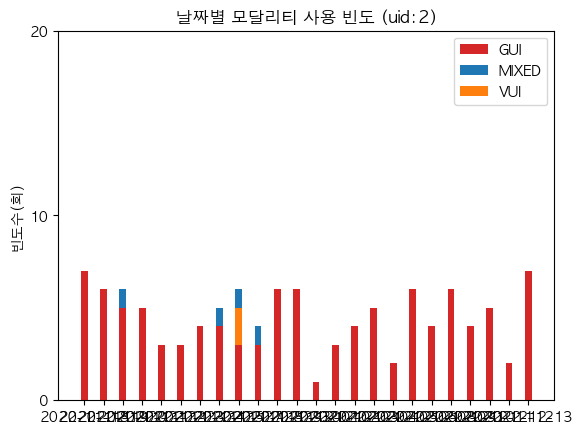

In [30]:
draw_graph_individual(2, complete) #parameters : uid, complete_df